In [1]:
!pip install pandas scikit-learn matplotlib seaborn joblib requests

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import requests, zipfile, io

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('data')
df = pd.read_csv('data/SMSSpamCollection', sep='\t', names=['label', 'text'])
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Dataset shape: (5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


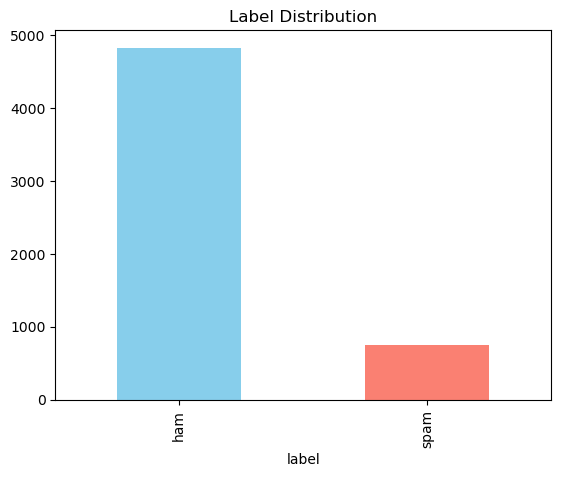

In [4]:
print('Dataset shape:', df.shape)
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar', title='Label Distribution', color=['skyblue','salmon']);

In [5]:
def clean_text(s):
    s = s.str.lower()
    s = s.str.replace(r'[^a-z0-9\s]', '', regex=True)
    s = s.str.replace(r'\s+', ' ', regex=True).str.strip()
    return s

df['text_clean'] = clean_text(df['text'])
df['target'] = df['label'].map({'ham':0, 'spam':1})
df.head()

,label,text,text_clean,target
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,1
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,0


In [6]:
X = df['text_clean']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

Train size: 4457 Test size: 1115


In [7]:
baseline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9811659192825112
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [8]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])
params = {
    'tfidf__ngram_range': [(1,1),(1,2)],
    'clf__C': [0.1,1.0]
}
cv = GridSearchCV(pipe, params, cv=3, scoring='f1', n_jobs=-1)
cv.fit(X_train, y_train)
print('Best params:', cv.best_params_)
best_model = cv.best_estimator_

Best params: {'clf__C': 1.0, 'tfidf__ngram_range': (1, 1)}


Accuracy: 0.9659192825112107
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



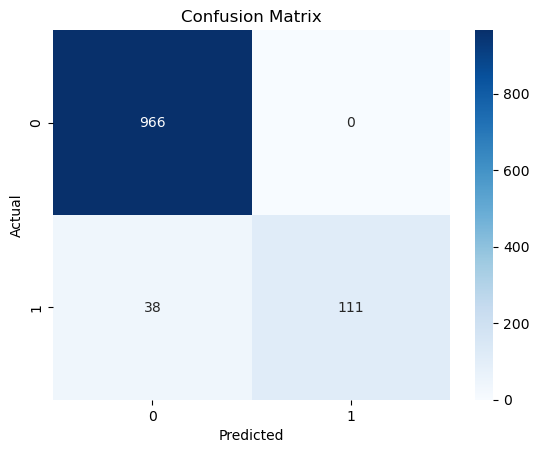

In [9]:
y_pred = best_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix'); plt.show()

In [10]:
joblib.dump(best_model, 'spam_model.joblib')
print('Model saved as spam_model.joblib')

examples = ['Free entry to win an iPhone', 'Are you free for lunch?']
preds = best_model.predict(clean_text(pd.Series(examples)))
print(list(zip(examples, preds)))

Model saved as spam_model.joblib
[('Free entry to win an iPhone', 1), ('Are you free for lunch?', 0)]
